In [46]:
import os
import math
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
path = "/Users/jorgerag/Documents/UCSD/courses/Winter23/COGS181/final_project/"
os.chdir(path)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [47]:
def get_source(df):
    res = []
    for i in range(0, len(df)):
        res.append(np.array(df["gcamp_lp"].iloc[i], dtype="float32"))
    res = np.array(res)
    return torch.from_numpy(res[1:])

def get_categories(df):
    conditions = [
        (df['lp_duration'] < 200),
        (df['lp_duration'] >= 200) & (df['lp_duration'] < 400),
        (df['lp_duration'] >= 400) & (df['lp_duration'] < 600),
        (df['lp_duration'] >= 600) & (df['lp_duration'] < 800),
        (df['lp_duration'] >= 800) & (df['lp_duration'] < 1000),
        (df['lp_duration'] >= 1000) & (df['lp_duration'] < 1200),
        (df['lp_duration'] >= 1200) & (df['lp_duration'] < 1400),
        (df['lp_duration'] >= 1400) & (df['lp_duration'] < 1600),
        (df['lp_duration'] >= 1600) & (df['lp_duration'] < 1800),
        (df['lp_duration'] >= 1800)
    ]
    cat = list(range(10))
    df['lp_cat'] = np.select(conditions, cat)
    return df

In [48]:
class PositionalEncoding(
    nn.Module,
):
    # needs to go at the bottom of the encoder and decoder stacks
    def __init__(self, d_model, dropout: float = 0.1, max_len: int = 3000):
        super().__init__()

        # Hyperparameter: to introduce regularization that prevents against overfitting
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        pe = torch.squeeze(pe)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :].requires_grad_(False)
        return self.dropout(x)

In [83]:
class Transformer(nn.Module):

    # input var
    def __init__(
        self,
        dim_val,
        encoder_dim_feedforward_d_model_scalar,
        encoder_dropout,
        encoder_num_layers,
        encoder_activation,
        encoder_num_heads,
        decoder_dim_feedforward_d_model_scalar,
        decoder_dropout,
        decoder_num_layers,
        decoder_num_heads,
        decoder_activation,
        max_seq,
        num_classes, 
        embedding_size
    ):
        
        super().__init__()
        self.encoder_input_layer = nn.Linear(in_features=max_seq, out_features=dim_val)
        self.positional_encoding = PositionalEncoding(dim_val, max_len=max_seq)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val,
            nhead=encoder_num_heads,
            dim_feedforward=dim_val * encoder_dim_feedforward_d_model_scalar,
            dropout=encoder_dropout,
            activation=encoder_activation)
        self.encoder = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=encoder_num_layers)
        self.embedding = nn.Embedding(num_classes, embedding_size)
        self.decoder_input_layer = nn.Linear(in_features=embedding_size, out_features=dim_val)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=decoder_num_heads,
            dim_feedforward=dim_val * decoder_dim_feedforward_d_model_scalar,
            dropout=decoder_dropout,
            activation=decoder_activation)
        self.decoder = nn.TransformerDecoder(decoder_layer=decoder_layer, num_layers=decoder_num_layers)
        self.linear_mapping = nn.Linear(in_features=dim_val, out_features=num_classes)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, source, target):
        source = self.encoder_input_layer(source)
        source = self.positional_encoding(source)
        source = self.encoder(src=source)
        target = self.embedding(target)
        target = self.decoder_input_layer(target)
        target = self.decoder(tgt=target, memory=source)
        target = self.linear_mapping(target)
        target = self.softmax(target)
        return target

In [84]:
trainingset = pd.DataFrame(pd.read_json("data/processed/train_data.json"))
testset = pd.DataFrame(pd.read_json("data/processed/test_data.json"))
# drop infs
trainingset = trainingset[~trainingset.isin([np.nan, np.inf, -np.inf]).any(1)]
testset = testset[~testset.isin([np.nan, np.inf, -np.inf]).any(1)]

trainingset = get_categories(trainingset)
testset = get_categories(testset)

/var/folders/mj/fbzmtcxx50g7hksjvdvr0kh00000gn/T/ipykernel_60897/627549247.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  trainingset = trainingset[~trainingset.isin([np.nan, np.inf, -np.inf]).any(1)]
/var/folders/mj/fbzmtcxx50g7hksjvdvr0kh00000gn/T/ipykernel_60897/627549247.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  testset = testset[~testset.isin([np.nan, np.inf, -np.inf]).any(1)]


In [85]:
# Get valdiation split
unique_obj = trainingset.groupby(["subject", "threshold", "day"]).size().reset_index()
unique_obj = unique_obj.to_dict('records')
unique_obj_df = pd.DataFrame(unique_obj)[['subject', 'day']]
# Split to train and validation
## Take one trial per subject as validation choosing randonmly from each of the subjects with more than one day.
validation_trials = unique_obj_df[~unique_obj_df["subject"].isin([3203, 3315])].groupby('subject').apply(lambda x: x.sample(n = 1, random_state = 123)).reset_index(drop=True)
keys = list(validation_trials.columns.values)
i1 = trainingset.set_index(keys).index
i2 = validation_trials.set_index(keys).index

train_df = trainingset[~i1.isin(i2)]
validation_df = trainingset[i1.isin(i2)]

In [86]:
## Divide datasets by trials
gb = train_df.groupby(["subject", "day"])
trials = [gb.get_group(x) for x in gb.groups]

gb_val = validation_df.groupby(["subject", "day"])
val_trials = [gb_val.get_group(x) for x in gb_val.groups]

gb_test = testset.groupby(["subject", "day"])
test_trials = [gb_test.get_group(x) for x in gb_test.groups]

In [87]:
dim_val = 100
n_heads = 10
n_decoder_layers = 4
n_encoder_layers = 4
max_seq = 703
embedding_size = 10
num_classes = 10

epochs = 50
lr = 0.001
momentum = 0.9
loss_function = torch.nn.CrossEntropyLoss()

model = Transformer(
    dim_val=dim_val,
    encoder_dim_feedforward_d_model_scalar=5,
    encoder_dropout=0.5,
    encoder_num_layers=n_encoder_layers,
    encoder_activation="relu",
    encoder_num_heads=n_heads,
    decoder_dim_feedforward_d_model_scalar=5,
    decoder_dropout=0.5,
    decoder_num_layers=n_decoder_layers,
    decoder_num_heads=n_heads,
    decoder_activation="relu",
    max_seq=max_seq,
    num_classes=num_classes,
    embedding_size=embedding_size
)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [88]:
all_losses = []
for epoch in range(epochs):
    train_loss = 0
    target_list = []
    predicted_total = []
    model.train()
    for trial in trials:
        optimizer.zero_grad()
        source = get_source(trial)
        # Padding source to max lenght of sequence
        source = F.pad(source, pad=(0, 0, 0, max_seq + 1 - len(trial)), mode="constant", value=0).T
        residual = source
        target = torch.tensor(trial["lp_cat"][1:].values).to(torch.int64)
        target_list = target_list + torch.squeeze(target).tolist()
        predicted_lp = model(source=source, target=target)
        loss = loss_function(predicted_lp, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * source.size(1)
        predicted_total = predicted_total + torch.squeeze(predicted_lp).tolist()[:len(trial)]
    all_losses.append(train_loss / len(trials))
    print("-------------------------------------")
    print("Average Training Loss:", train_loss / len(trials))
    # Print train accuracy.
    correct = 0
    total = 0
    predicted_total = torch.tensor(predicted_total)
    predicted = torch.max(predicted_total.data, 1)[1]
    for i in range(0, len(predicted)):
        total += 1
        if predicted[i] == target_list[i]:
            correct += 1
    print('Train Accuracy: %d %%' % (100 * correct / total))
    # Print validation accuracy
    model.eval()
    target_val_list = []
    predicted_val_total = []
    for val in val_trials:
        source_val = get_source(val)
        source_val = F.pad(source_val, pad=(0, 0, 0, max_seq + 1 - len(val)), mode="constant", value=0).T
        target_val = torch.tensor(val["lp_cat"][1:].values).to(torch.int64)
        target_val_list = target_val_list + torch.squeeze(target_val).tolist()
        with torch.no_grad():
            predicted_val = model(source=source_val, target=target_val)
            predicted_val_total = predicted_val_total + torch.squeeze(predicted_val).tolist()[:len(val)]
    correct_val = 0
    total_val = 0
    predicted_val_total = torch.tensor(predicted_val_total)
    predicted_val_cat = torch.max(predicted_val_total.data, 1)[1].tolist()
    for i in range(0, len(predicted_val_cat)):
        total_val += 1
        if predicted_val_cat[i] == target_val_list[i]:
            correct_val += 1
    print('Validation Accuracy: %d %%' % (100 * correct_val / total_val))

-------------------------------------
Average Training Loss: 1628.5608878135681
Train Accuracy: 4 %
Validation Accuracy: 3 %
-------------------------------------
Average Training Loss: 1621.5198500156403
Train Accuracy: 6 %
Validation Accuracy: 8 %
-------------------------------------
Average Training Loss: 1607.49973654747
Train Accuracy: 12 %
Validation Accuracy: 21 %
-------------------------------------
Average Training Loss: 1586.9129784107208
Train Accuracy: 16 %
Validation Accuracy: 21 %
-------------------------------------
Average Training Loss: 1559.3499674797058
Train Accuracy: 14 %
Validation Accuracy: 21 %
-------------------------------------
Average Training Loss: 1538.7996685504913
Train Accuracy: 15 %
Validation Accuracy: 21 %
-------------------------------------
Average Training Loss: 1518.7910706996918
Train Accuracy: 34 %
Validation Accuracy: 35 %
-------------------------------------
Average Training Loss: 1497.5288689136505
Train Accuracy: 55 %
Validation Accur

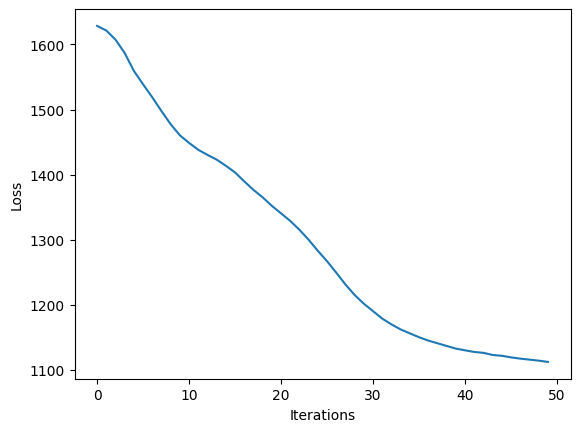

In [89]:
# Training Curve
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot([loss for loss in all_losses])
plt.show()

In [90]:
# Print test accuracy
model.eval()
target_test_list = []
predicted_test_total = []
for test in test_trials:
    source_test = get_source(test)
    source_test = F.pad(source_test, pad=(0, 0, 0, max_seq + 1 - len(test)), mode="constant", value=0).T
    target_test = torch.tensor(test["lp_cat"][1:].values).to(torch.int64)
    target_test_list = target_test_list + torch.squeeze(target_test).tolist()
    with torch.no_grad():
        predicted_test = model(source=source_test, target=target_test)
        predicted_test_total = predicted_test_total + torch.squeeze(predicted_test).tolist()[:len(test)]
correct_test = 0
total_test = 0
predicted_test_total = torch.tensor(predicted_test_total)
predicted_test_cat = torch.max(predicted_test_total.data, 1)[1].tolist()
for i in range(0, len(predicted_test_cat)):
    total_test += 1
    if predicted_test_cat[i] == target_test_list[i]:
        correct_test += 1
print('Test Accuracy: %d %%' % (100 * correct_test / total_test))

Test Accuracy: 89 %


Check data separation

In [91]:
check = []
for elem in [trials, val_trials, test_trials]:
    for i in range(0, len(elem)):
        unique_check = {}
        unique_check['subject'] = elem[i][['subject']].iloc[0][0]
        unique_check['day'] = elem[i][['day']].iloc[0][0]
        check.append(unique_check)
sorted(check, key=lambda k: (k['subject'], k['day']))


[{'subject': 3201, 'day': 2},
 {'subject': 3201, 'day': 4},
 {'subject': 3201, 'day': 5},
 {'subject': 3201, 'day': 6},
 {'subject': 3203, 'day': 2},
 {'subject': 3203, 'day': 3},
 {'subject': 3204, 'day': 4},
 {'subject': 3204, 'day': 5},
 {'subject': 3204, 'day': 6},
 {'subject': 3315, 'day': 3},
 {'subject': 3315, 'day': 6},
 {'subject': 3316, 'day': 2},
 {'subject': 3316, 'day': 3},
 {'subject': 3316, 'day': 4},
 {'subject': 3316, 'day': 5},
 {'subject': 3316, 'day': 6},
 {'subject': 3317, 'day': 1},
 {'subject': 3317, 'day': 3},
 {'subject': 3317, 'day': 5},
 {'subject': 4268, 'day': 1},
 {'subject': 4268, 'day': 2},
 {'subject': 4268, 'day': 3},
 {'subject': 4268, 'day': 4},
 {'subject': 4268, 'day': 5},
 {'subject': 4268, 'day': 6},
 {'subject': 4268, 'day': 7},
 {'subject': 4268, 'day': 8},
 {'subject': 4269, 'day': 1},
 {'subject': 4269, 'day': 3},
 {'subject': 4269, 'day': 5},
 {'subject': 4269, 'day': 6},
 {'subject': 4269, 'day': 7},
 {'subject': 4269, 'day': 8}]